#  Machine Learning - Spring 2019

## Mini-Project II

### Learning Algorithm: Classifier

Created on March 10, 2019 by Diogo Cosin <d.ayresdeoliveira@jacobs-university.de> and Ralph Florent <r.florent@jacobs-university.de>.

### Description
Train a classifier for the Digits dataset by implementing a full processing pipeline from feature extraction to (linear) classifier training, attempting to squeeze performance out of the classifier using cross-validation and regularization techniques.

### Summary
The script below is intended to... 

WIP

Note: The algorithm is tested on the OCR datasets from the `DigitsBasicsRoutine.zip`, which was provided by Professor Dr. H. Jaeger, Machine Learning Professor at [Jacobs University Bremen](https://www.jacobs-university.de).

In [1]:
""" Learning Algorithm: Classifier """

# -*- coding: utf-8 -*-
# 
# Created on April 01, 2019
# Authors: 
#        Diogo Cosin <d.ayresdeoliveira@jacobs-university.de>,
#        Ralph Florent <r.florent@jacobs-university.de>


# Import relevant libraries
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy


### START: scripts
PATTERN_SIZE = 200 # predefined number of class patterns available

def get_data_points(digit = -1):
    """ Get a specific subset of data points from the multi-feature digit dataset
    
    This dataset consists of features of handwritten numerals (`0'--`9')
    extracted from a collection of Dutch utility maps. 200 patterns per
    class (for a total of 2,000 patterns) have been digitized in  binary
    images.
    
    Read more in the :ref:`../assets/mfeat.info`.
    
    Parameters
    ----------
    digit: int, default = -1
        The digit-class pattern between zero(0) and nine(9) 
    
    Returns
    -------
    data_points: array
        The data points of the class pattern of the specified digit
        If no specified digit, it returns the entire data points
    """
    filepath = './assets/mfeat-pix.txt'
    data_points = np.loadtxt(filepath)
    
    if(digit >= 0 and digit <= 9):
        START = digit * PATTERN_SIZE
        END   = START + PATTERN_SIZE
        return data_points[START:END] 
    return data_points # numpy.ndarray([ points[], ..., N])


def assign_randomly(data, K):
    """ Group a given dataset by K-shuffled-groups  
    
    Using the helper function `numpy.random.shuffle()` to randomly shuffle
    the array-like dataset, assign every point to a K-group.
    
    Parameters
    ----------
    data: array of shape(n_samples)
        The digit-class pattern between zero(0) and nine(9) 
    K: int
        Number of desired groups. K cannot be bigger the number of rows of
        the given sample. If yes, K will be reshaped to the very size of 
        the sample.
    
    Returns
    -------
    data: array of {array-like, sparse matrix} shape = [k_groups, n_data_points]
        The set of groups containing a subset of data points
        such as: arr(data[ arr(groups[ arr(points),..., n]), ..., K])
    """
    np.random.shuffle(data)
    if K > len(data): # protect array
        K = len(data)
    return np.array([ data[i::K] for i in range(K) ])


def to_list(nested_array):
    """ Convert nested arrays into nested lists
    
    Parameters
    ----------
    nested_array: array of arrays
        The set of arrays to be converted
    
    Returns
    -------
    data: list
        The converted-into-list data
    """
    if not isinstance(nested_array, np.ndarray):
        return nested_array
    return [ to_list(arr) for arr in nested_array ]


def to_array(nested_list):
    """ Convert nested lists into nested arrays
    
    Parameters
    ----------
    nested_list: list of lists
        The set of lists to be converted
    
    Returns
    -------
    data: array {numpy.ndarray}
        The converted-into-array data
    """
    if not isinstance(nested_list, list):
        return nested_list
    return np.array([ to_array(l) for l in nested_list ])


def get_codebooks(clusters):
    """ Get the codebook vector image from the set of clusters
    
    This function computes the mean of each cluster and assign
    each codebook accordingly to form an array of shape(K_codebooks).
    
    Parameters
    ----------
    clusters:  array of shape(K_clusters)
        The set of K-codebook images from the clusters
    
    Returns
    -------
    data: array of shape (K_codebooks)
        The set of codebooks computed from each cluster
    """
    return np.array([ np.mean(c, axis=0) for c in clusters])
    

def k_mean(data, K = 1):
    """ Compute the K-Means clustering Machine Learning Algorithm
    
    This basically groups data points into K-clusters based on their
    similarities.
    
    Read more in the :ref:`http://minds.jacobs-university.de/uploads/teaching/lectureNotes/LN_ML4IMS.pdf`.
    
    Parameters
    ----------
    data: array-like, shape([n_samples, m_features])
        The data points to be clustered
    K: int
        The number of desired clusters
    
    Returns
    -------
    clusters: array {numpy.ndarray}
        The k-clustered subsets of data points containing similar traits
    """
    
    # K random positions to assign Set of clusters Sj
    clusters = assign_randomly(data, K)
    
    # Iterate over the Sj while computing Modulus(xi − µj) 
    while True:
        clone_clusters = [[] for i in range(K)] # clone clusters: list
        
        for point in data:
            distances = [] # between data points and mean cluster
            for j in range(K):
                # compute mean of the cluster: codebook vector
                mean_cluster = np.mean(clusters[j], axis=0)
                
                # compute distance between data point and mean cluster 
                distance = np.linalg.norm(point - mean_cluster)
                distances.append(distance)
                
            # Put point into the cluster where the distance is minimal 
            which_cluster = distances.index( min(distances) )
            clone_clusters[ which_cluster ].append( list(point) )
        
        # remove cluster if it is empty
        for cluster in clone_clusters:
            if not cluster:
                clone_clusters.remove(cluster)
                K -= 1
        
        # check if sets remain unchanged 
        if clone_clusters == to_list(clusters): break
            
        # update to optimal clusters
        clusters  = to_array( deepcopy(clone_clusters) )
        
    return clusters


def plot_figure(dataset):
    """ Plot the set of image vectors
    
    This basically reshapes every vector image into 15x16 Matrix-sized
    set and plot the image in a 11x6.5-in figure.
    
    
    Parameters
    ----------
    dataset: array of data points
        The data points representing the class pattern images
    """
    n_vectors = len(dataset)
        
    fig = plt.figure(figsize=(11, 6.5))
    for i in range(n_vectors):
        graph = fig.add_subplot(10, 20, i + 1)
        graph.imshow(dataset[i].reshape(16, 15), cmap='binary')
        graph.axis('off')
    plt.show()


### Visualizations of the `x-digit` subset

The `get_data_points(digit)` function helps to obtain a specific subset of the selected digit between 0-9. In case no digits are specified, it loads the entire 2000 datapoints from the local file `./assets/mfeat-pix.txt`.

For example, to load the five-digit subset, the function `get_data_points(5)` is to be called.

### Another example of digit-class data loading

Let's load this time the 7-digit class pattern from the dataset.

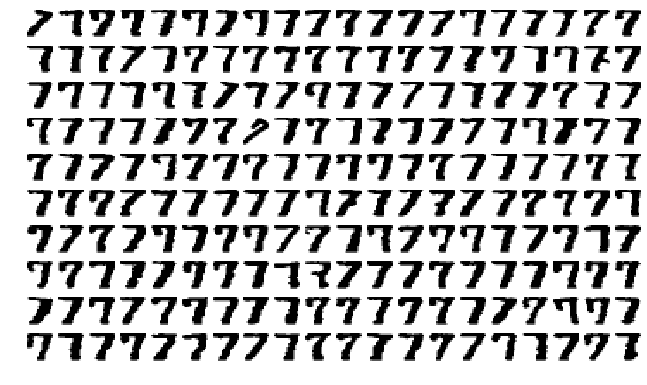

In [2]:
# Load the seven-class data points from the OCR datasets.
sevens = get_data_points(7)

# Visualize dataset for the `sevens` subset
plot_figure(sevens)

### Loading training and testing data


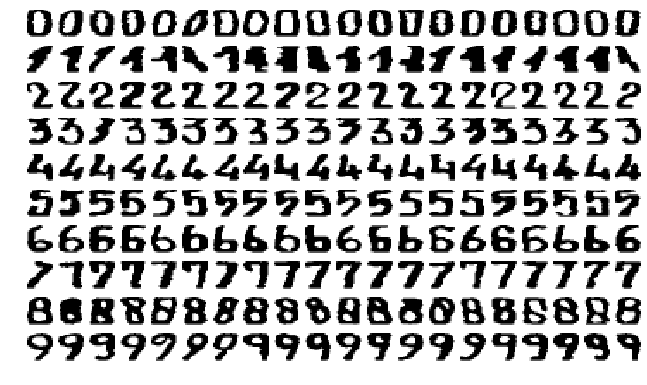

In [4]:
# Let's form a new dataset by gathering different digit-class patterns
# since the zeros and sevens are already loaded, let's get the other digits
RANGE_LIMIT = 20

zero  = get_data_points(0)[0:RANGE_LIMIT]
one   = get_data_points(1)[0:RANGE_LIMIT]
two   = get_data_points(2)[0:RANGE_LIMIT]
three = get_data_points(3)[0:RANGE_LIMIT]
four  = get_data_points(4)[0:RANGE_LIMIT]
five  = get_data_points(5)[0:RANGE_LIMIT]
six   = get_data_points(6)[0:RANGE_LIMIT]
seven = sevens[0:RANGE_LIMIT]
eight = get_data_points(8)[0:RANGE_LIMIT]
nine  = get_data_points(9)[0:RANGE_LIMIT]
    
mixed_digits = np.concatenate((zero, one, two, three, four, five, six, seven, eight, nine), axis=0)
# Visualize dataset for the zeros dataset
plot_figure(mixed_digits)

### Now that we have a dataset of mixed digits, let's run K-means clustering on it
First, let's run the algorithm for the `mixed_digits` where K = 1, 2, 3, 200. Then, we will visualize the respective generated clusters.

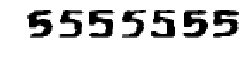

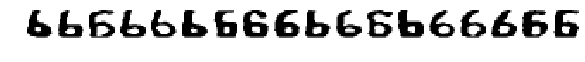

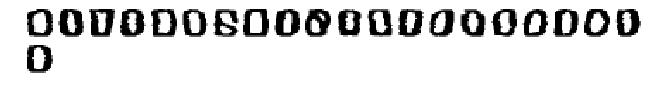

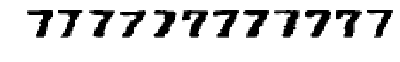

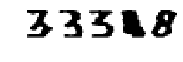

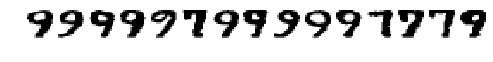

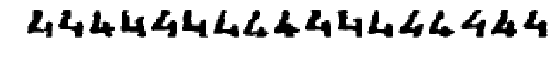

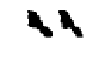

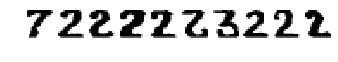

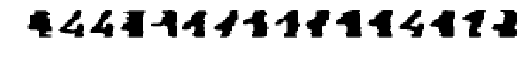

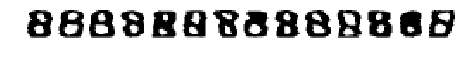

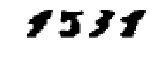

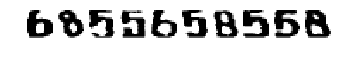

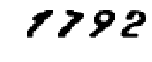

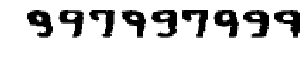

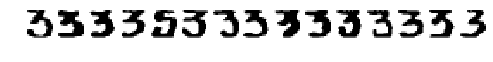

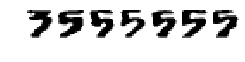

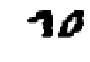

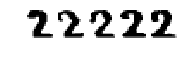

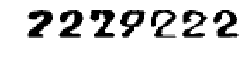

In [5]:
# Run k-means algorithm on the data set for the mixed-digit class patterns for K = 20
mixed_digits_clustered_20 = k_mean(mixed_digits, 20)

# Visualize dataset for the mixed_digits_clustered_20 dataset
for cluster in mixed_digits_clustered_20:
    plot_figure(cluster)